In [1]:
from general_tools.notebook.gpu_utils import setup_one_gpu
GPU = 2
setup_one_gpu(GPU)

Picking GPU 2


In [2]:
from scipy.io import loadmat
from geo_tool import Point_Cloud
import matplotlib.pylab as plt
from scipy.spatial.distance import pdist
import numpy as np
import tensorflow as tf

In [3]:
from tflearn.layers.core import fully_connected
from tf_lab.point_clouds.encoders_decoders import encoder_with_convs_and_symmetry_new, decoder_with_fc_only
from tf_lab.data_sets.numpy_dataset import NumpyDataset

In [ ]:
from numpy.linalg import norm

In [4]:
%matplotlib inline

In [36]:
# LOAD Data
fmaps = '/orions4-zfs/projects/optas/DATA/OUT/latent_parametric_models/lhsmat32.mat'
fmaps = loadmat(fmaps)['lhsmat']

params = '/orions4-zfs/projects/optas/DATA/OUT/latent_parametric_models/rhsmat32.mat'
params = loadmat(params)['rhsmat']

In [37]:
thres = 1e-6
fmaps[abs(fmaps) < thres] = 0
fmaps = np.rollaxis(fmaps, 2, 0)
params = params.transpose()

In [42]:
split = 1800
train_fmaps = fmaps[:split]
test_fmaps = fmaps[split:]
train_params = params[:split]
test_params = params[split:]

In [43]:
train_data = NumpyDataset([train_fmaps, train_params], ['fmaps', 'params'])
test_data = NumpyDataset([test_fmaps, test_params], ['fmaps', 'params'])

['fmaps', 'params']
['fmaps', 'params']


In [48]:
n_latent = fmaps.shape[1]
n_regressor = params.shape[1]

In [79]:
in_fmaps = tf.placeholder(tf.float32, shape=(None, n_latent, n_latent))
in_labels = tf.placeholder(tf.float32, shape=[None, n_regressor])
net_out = decoder_with_fc_only(in_fmaps, layer_sizes=[20, 20, n_regressor])
net_out = tf.nn.relu(net_out)
problem_loss = tf.losses.mean_squared_error(in_labels, net_out)

In [80]:
learning_rate = 0.001
opt = tf.train.AdamOptimizer(learning_rate)
opt_step = opt.minimize(problem_loss)

In [81]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
init=tf.global_variables_initializer()
sess.run(init)

In [86]:
batch_size = 50
steps_per_epoch = train_data.n_examples / batch_size
max_epochs = 20
losses_per_epoch = []

for epoch in range(max_epochs):
    total_loss = 0.0
    for _ in range(steps_per_epoch):
        f, p = train_data.next_batch(batch_size)
        feed_dict = {in_fmaps:f, in_labels:p}
        _, l =sess.run([opt_step, problem_loss], feed_dict=feed_dict)
        total_loss += l        
    losses_per_epoch.append(total_loss / float(steps_per_epoch))
    print losses_per_epoch[-1], loss_on_test(test_data)

0.0308578217195 [0.065277383]
0.0309070274234 [0.065784387]
0.0299088238842 [0.065598078]
0.0305827625303 [0.065631524]
0.0291280402905 [0.066567391]
0.0301061295387 [0.065252505]
0.029432560369 [0.066385277]
0.0296046233529 [0.065687418]
0.0293777066593 [0.066242151]
0.0289021830799 [0.066338778]
0.0289907762781 [0.065070219]
0.0287428568635 [0.066467859]
0.0282371911324 [0.065835617]
0.0283515454891 [0.065238044]
0.0286126776288 [0.066375569]
0.0280086469009 [0.065429524]
0.0276198158972 [0.066849858]
0.0278730547159 [0.065490685]
0.028002074247 [0.066800088]
0.027592913765 [0.066928625]


In [89]:
def loss_on_test(test_data):
    f = test_data.fmaps
    p = test_data.params
    feed_dict = {in_fmaps:f, in_labels:p}
    total_loss = sess.run([problem_loss], feed_dict=feed_dict)
    return total_loss

def predict_on_test(test_data):
    f = test_data.fmaps
    p = test_data.params
    feed_dict = {in_fmaps:f, in_labels:p}
    return sess.run([net_out], feed_dict=feed_dict)

In [93]:
import matplotlib.pylab as plt
%matplotlib inline

In [102]:
test_predictions.shape

AttributeError: 'list' object has no attribute 'shape'

In [127]:
np.mean(norm(test_predictions - test_data.params, axis=1))

0.87143507278866483

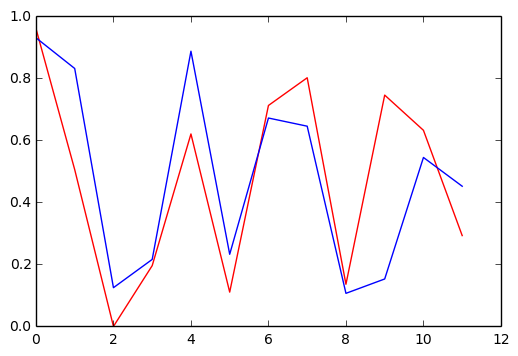

In [111]:
test_predictions = predict_on_test(test_data)[0]
k = 6
plt.plot(range(n_regressor), test_predictions[k], 'r')
plt.plot(range(n_regressor), test_data.params[k], 'b')